<a href="https://colab.research.google.com/github/agarr3/vajra-new/blob/main/AE_HYBRID_LSTM_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
criterion = nn.MSELoss()
n_epochs = 30
print_every = 1

BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/"

input_bins = 48
seq_len=200
AE_encoded_dim = 64

print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/"
DATA_SONG_DIR = "48Bins"
DATA_IMG_DIR = "48Bins"

files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk("/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Western_mel_numpy"):
  for file in fileList:
    if(file not in exclusion):
      files.append([file,file, "Western_mel_numpy"])
    else:
      print(file)

random.seed(1234)
files = random.sample(files, 2008)

for r,d, fileList in os.walk("/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Indian_mel_numpy"):
  for file in fileList:
    if(True):
      files.append([file,file, "Indian_mel_numpy"])
    else:
      print(file)

dataDF = pd.DataFrame(files, columns=['Images','songs','labels'])
dataDF.head()

,Images,songs,labels
0,039357.npy,039357.npy,Western_mel_numpy
1,107591.npy,107591.npy,Western_mel_numpy
2,143217.npy,143217.npy,Western_mel_numpy
3,140623.npy,140623.npy,Western_mel_numpy
4,147059.npy,147059.npy,Western_mel_numpy


In [5]:
dataDF.groupby("labels").count()

,Images,songs
labels,,
Indian_mel_numpy,2008,2008
Western_mel_numpy,2008,2008


/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Western_mel_numpy/053576.npy
80.0


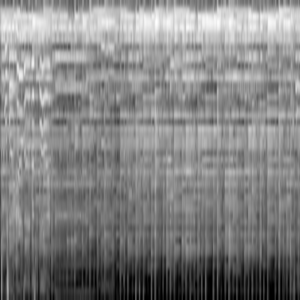

In [7]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, dataDF.loc[test_idx, 'labels'], dataDF.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



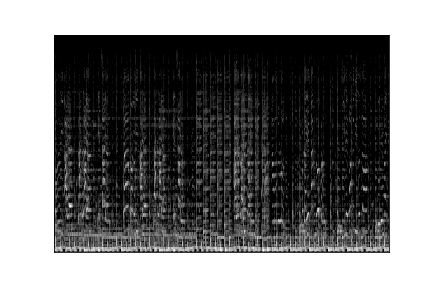

In [8]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [9]:
lb = LabelEncoder()
dataDF['encoded_labels'] = lb.fit_transform(dataDF['labels'])
dataDF.head()

,Images,songs,labels,encoded_labels
0,039357.npy,039357.npy,Western_mel_numpy,1
1,107591.npy,107591.npy,Western_mel_numpy,1
2,143217.npy,143217.npy,Western_mel_numpy,1
3,140623.npy,140623.npy,Western_mel_numpy,1
4,147059.npy,147059.npy,Western_mel_numpy,1


In [10]:
classes = ('Indian_numpy', 'Western_numpy')
dataDF.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_mel_numpy,0,2008,2008
Western_mel_numpy,1,2008,2008


In [12]:
from sklearn.model_selection import train_test_split

dataDF = dataDF.sample(frac=1)
df_train, df_test = train_test_split(dataDF, test_size=validation_split, stratify=dataDF[["labels"]])

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_mel_numpy,0,1406,1406
Western_mel_numpy,1,1405,1405


In [14]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_mel_numpy,0,602,602
Western_mel_numpy,1,603,603


In [15]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [16]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        return data, label



In [17]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

In [18]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [19]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

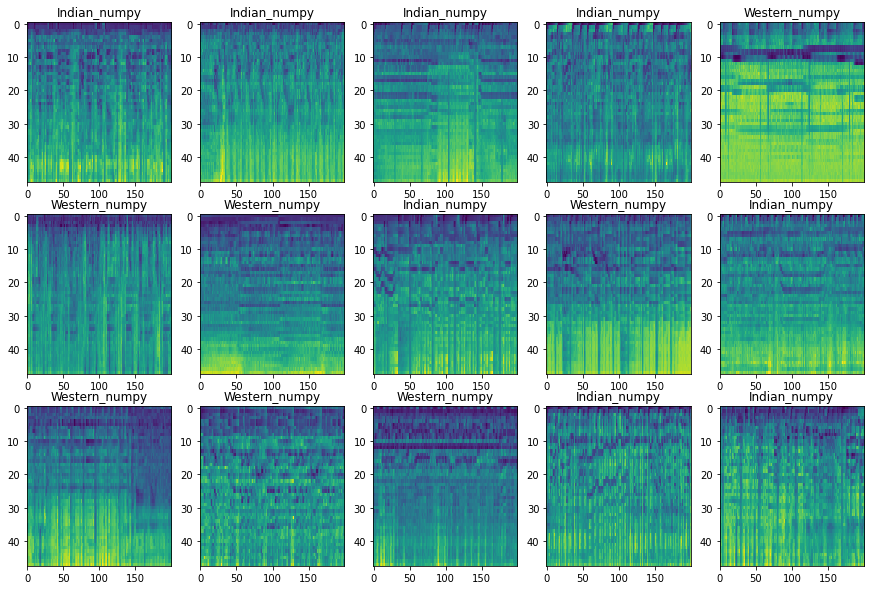

In [20]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

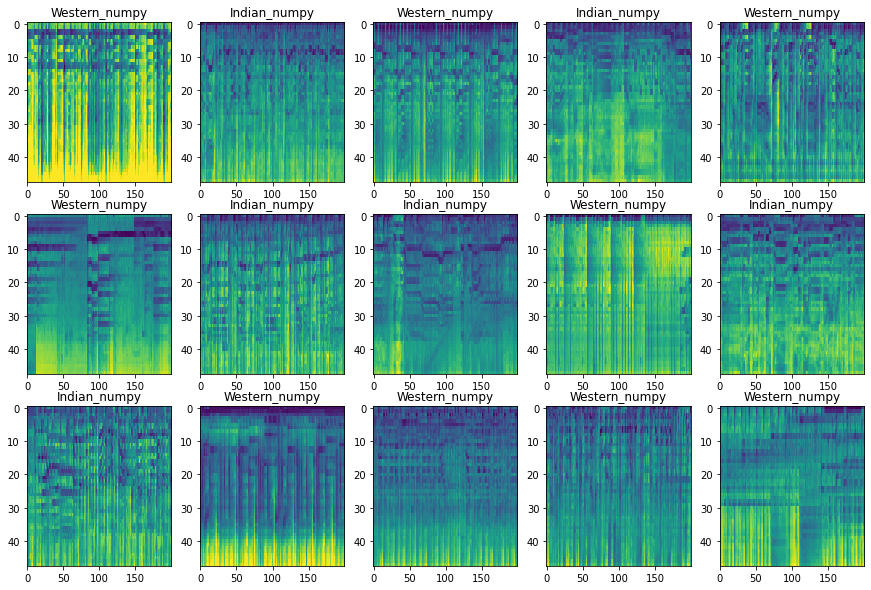

In [21]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [22]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(42, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=9600, bias=True)
  )
)

In [23]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1302.329
[1,     2] loss: 1260.320
[1,     3] loss: 1318.776
[1,     4] loss: 1099.920
[1,     5] loss: 1058.353
[1,     6] loss: 811.514
[1,     7] loss: 594.540
[1,     8] loss: 300.374
[1,     9] loss: 201.634
[1,    10] loss: 397.258
[1,    11] loss: 246.087
[1,    12] loss: 141.152
[1,    13] loss: 144.456
[1,    14] loss: 107.895
[1,    15] loss: 175.105
[1,    16] loss: 156.650
[1,    17] loss: 147.893
[1,    18] loss: 121.922
[1,    19] loss: 138.653
[1,    20] loss: 137.305
[1,    21] loss: 134.576
[1,    22] loss: 143.009
[1,    23] loss: 132.318
[1,    24] loss: 152.612
[1,    25] loss: 144.255
[1,    26] loss: 125.836
[1,    27] loss: 118.544
[1,    28] loss: 140.021
[1,    29] loss: 156.656
[1,    30] loss: 115.380
[1,    31] loss: 111.267
[1,    32] loss: 116.613
[1,    33] loss: 87.667
[1,    34] loss: 121.416
[1,    35] loss: 105.958
[1,    36] loss: 116.640
[1,    37] loss: 118.132
[1,    38] loss: 111.027
[1,    39] loss: 102.309
[1,    40] loss: 122.

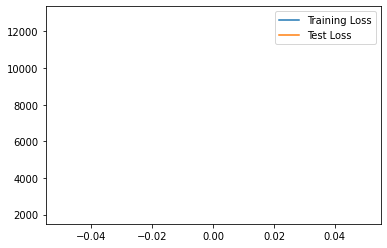

[2,     1] loss: 105.453
[2,     2] loss: 84.762
[2,     3] loss: 131.763
[2,     4] loss: 102.357
[2,     5] loss: 140.258
[2,     6] loss: 100.709
[2,     7] loss: 108.564
[2,     8] loss: 108.614
[2,     9] loss: 95.807
[2,    10] loss: 111.497
[2,    11] loss: 123.391
[2,    12] loss: 118.634
[2,    13] loss: 115.154
[2,    14] loss: 88.868
[2,    15] loss: 104.648
[2,    16] loss: 93.996
[2,    17] loss: 92.905
[2,    18] loss: 86.660
[2,    19] loss: 104.172
[2,    20] loss: 110.000
[2,    21] loss: 106.462
[2,    22] loss: 103.604
[2,    23] loss: 96.336
[2,    24] loss: 111.653
[2,    25] loss: 107.299
[2,    26] loss: 93.422
[2,    27] loss: 92.194
[2,    28] loss: 112.586
[2,    29] loss: 126.280
[2,    30] loss: 96.103
[2,    31] loss: 85.719
[2,    32] loss: 89.804
[2,    33] loss: 77.434
[2,    34] loss: 84.822
[2,    35] loss: 74.447
[2,    36] loss: 83.693
[2,    37] loss: 85.378
[2,    38] loss: 75.834
[2,    39] loss: 66.772
[2,    40] loss: 79.936
[2,    41] loss: 83.

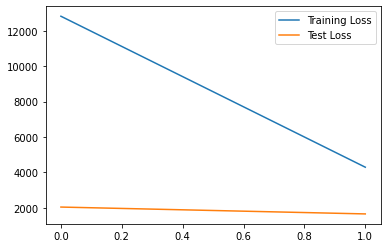

[3,     1] loss: 87.147
[3,     2] loss: 62.447
[3,     3] loss: 96.160
[3,     4] loss: 63.642
[3,     5] loss: 93.010
[3,     6] loss: 73.607
[3,     7] loss: 71.590
[3,     8] loss: 75.467
[3,     9] loss: 68.747
[3,    10] loss: 73.110
[3,    11] loss: 76.047
[3,    12] loss: 69.993
[3,    13] loss: 83.466
[3,    14] loss: 64.689
[3,    15] loss: 72.443
[3,    16] loss: 68.542
[3,    17] loss: 64.585
[3,    18] loss: 65.633
[3,    19] loss: 73.207
[3,    20] loss: 77.532
[3,    21] loss: 75.217
[3,    22] loss: 71.266
[3,    23] loss: 68.847
[3,    24] loss: 75.320
[3,    25] loss: 73.393
[3,    26] loss: 67.438
[3,    27] loss: 68.123
[3,    28] loss: 79.110
[3,    29] loss: 78.327
[3,    30] loss: 76.904
[3,    31] loss: 64.580
[3,    32] loss: 69.382
[3,    33] loss: 66.515
[3,    34] loss: 69.027
[3,    35] loss: 61.357
[3,    36] loss: 73.899
[3,    37] loss: 75.438
[3,    38] loss: 70.731
[3,    39] loss: 63.716
[3,    40] loss: 75.825
[3,    41] loss: 77.519
[3,    42] loss:

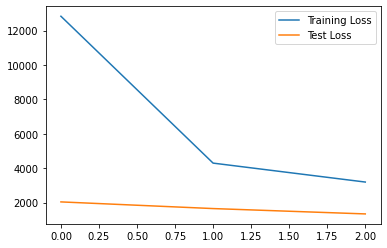

[4,     1] loss: 76.121
[4,     2] loss: 60.809
[4,     3] loss: 82.915
[4,     4] loss: 61.919
[4,     5] loss: 86.092
[4,     6] loss: 70.855
[4,     7] loss: 69.704
[4,     8] loss: 70.108
[4,     9] loss: 67.956
[4,    10] loss: 71.078
[4,    11] loss: 71.979
[4,    12] loss: 68.207
[4,    13] loss: 81.138
[4,    14] loss: 64.023
[4,    15] loss: 71.527
[4,    16] loss: 67.193
[4,    17] loss: 63.312
[4,    18] loss: 64.777
[4,    19] loss: 72.126
[4,    20] loss: 76.667
[4,    21] loss: 74.174
[4,    22] loss: 70.778
[4,    23] loss: 67.396
[4,    24] loss: 74.824
[4,    25] loss: 71.643
[4,    26] loss: 67.169
[4,    27] loss: 66.797
[4,    28] loss: 78.351
[4,    29] loss: 77.345
[4,    30] loss: 76.222
[4,    31] loss: 64.455
[4,    32] loss: 68.451
[4,    33] loss: 66.567
[4,    34] loss: 68.350
[4,    35] loss: 61.108
[4,    36] loss: 73.215
[4,    37] loss: 74.516
[4,    38] loss: 70.438
[4,    39] loss: 63.242
[4,    40] loss: 74.456
[4,    41] loss: 76.874
[4,    42] loss:

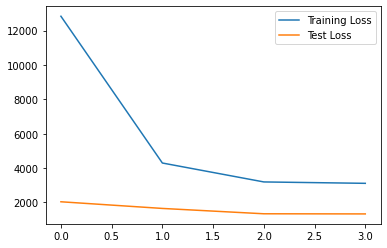

[5,     1] loss: 75.368
[5,     2] loss: 60.659
[5,     3] loss: 81.906
[5,     4] loss: 61.468
[5,     5] loss: 84.398
[5,     6] loss: 70.686
[5,     7] loss: 68.990
[5,     8] loss: 69.739
[5,     9] loss: 67.681
[5,    10] loss: 70.073
[5,    11] loss: 71.610
[5,    12] loss: 67.251
[5,    13] loss: 80.628
[5,    14] loss: 63.383
[5,    15] loss: 70.359
[5,    16] loss: 66.731
[5,    17] loss: 61.980
[5,    18] loss: 64.185
[5,    19] loss: 71.181
[5,    20] loss: 75.780
[5,    21] loss: 73.510
[5,    22] loss: 69.653
[5,    23] loss: 66.902
[5,    24] loss: 73.632
[5,    25] loss: 70.877
[5,    26] loss: 66.474
[5,    27] loss: 65.861
[5,    28] loss: 77.714
[5,    29] loss: 75.719
[5,    30] loss: 76.019
[5,    31] loss: 63.732
[5,    32] loss: 68.317
[5,    33] loss: 65.551
[5,    34] loss: 68.721
[5,    35] loss: 60.590
[5,    36] loss: 73.345
[5,    37] loss: 73.979
[5,    38] loss: 70.237
[5,    39] loss: 62.832
[5,    40] loss: 73.981
[5,    41] loss: 76.443
[5,    42] loss:

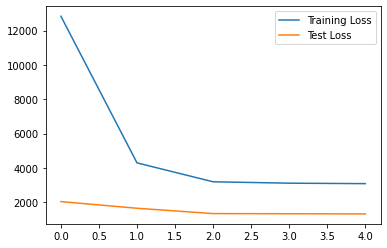

[6,     1] loss: 74.956
[6,     2] loss: 60.823
[6,     3] loss: 81.122
[6,     4] loss: 61.185
[6,     5] loss: 83.788
[6,     6] loss: 70.472
[6,     7] loss: 68.523
[6,     8] loss: 69.430
[6,     9] loss: 67.177
[6,    10] loss: 69.853
[6,    11] loss: 70.797
[6,    12] loss: 66.959
[6,    13] loss: 80.248
[6,    14] loss: 62.975
[6,    15] loss: 69.804
[6,    16] loss: 66.437
[6,    17] loss: 61.612
[6,    18] loss: 63.940
[6,    19] loss: 70.618
[6,    20] loss: 75.459
[6,    21] loss: 72.902
[6,    22] loss: 69.542
[6,    23] loss: 66.294
[6,    24] loss: 73.087
[6,    25] loss: 70.311
[6,    26] loss: 66.150
[6,    27] loss: 65.364
[6,    28] loss: 77.216
[6,    29] loss: 75.112
[6,    30] loss: 75.461
[6,    31] loss: 63.415
[6,    32] loss: 67.931
[6,    33] loss: 65.131
[6,    34] loss: 68.359
[6,    35] loss: 60.312
[6,    36] loss: 73.054
[6,    37] loss: 73.541
[6,    38] loss: 69.971
[6,    39] loss: 62.525
[6,    40] loss: 73.268
[6,    41] loss: 76.132
[6,    42] loss:

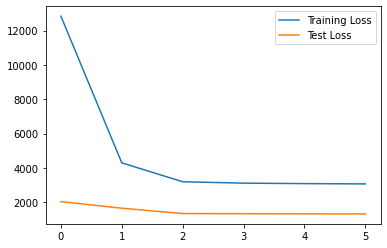

[7,     1] loss: 74.810
[7,     2] loss: 60.598
[7,     3] loss: 80.597
[7,     4] loss: 60.763
[7,     5] loss: 83.007
[7,     6] loss: 70.050
[7,     7] loss: 68.114
[7,     8] loss: 68.844
[7,     9] loss: 66.812
[7,    10] loss: 69.519
[7,    11] loss: 70.106
[7,    12] loss: 66.567
[7,    13] loss: 79.967
[7,    14] loss: 62.564
[7,    15] loss: 69.124
[7,    16] loss: 66.034
[7,    17] loss: 61.335
[7,    18] loss: 63.722
[7,    19] loss: 70.121
[7,    20] loss: 75.242
[7,    21] loss: 72.223
[7,    22] loss: 69.454
[7,    23] loss: 65.772
[7,    24] loss: 72.595
[7,    25] loss: 69.664
[7,    26] loss: 65.899
[7,    27] loss: 64.867
[7,    28] loss: 76.806
[7,    29] loss: 74.472
[7,    30] loss: 74.959
[7,    31] loss: 63.162
[7,    32] loss: 67.587
[7,    33] loss: 64.589
[7,    34] loss: 68.173
[7,    35] loss: 60.128
[7,    36] loss: 72.875
[7,    37] loss: 73.121
[7,    38] loss: 69.789
[7,    39] loss: 62.303
[7,    40] loss: 72.759
[7,    41] loss: 75.807
[7,    42] loss:

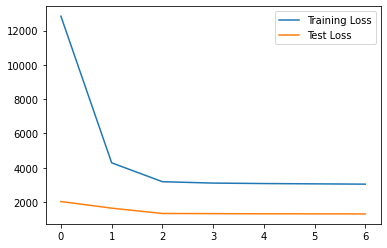

[8,     1] loss: 74.539
[8,     2] loss: 60.519
[8,     3] loss: 79.820
[8,     4] loss: 60.389
[8,     5] loss: 82.365
[8,     6] loss: 69.616
[8,     7] loss: 67.747
[8,     8] loss: 68.230
[8,     9] loss: 66.404
[8,    10] loss: 69.171
[8,    11] loss: 69.554
[8,    12] loss: 66.023
[8,    13] loss: 79.493
[8,    14] loss: 62.100
[8,    15] loss: 68.469
[8,    16] loss: 65.478
[8,    17] loss: 60.954
[8,    18] loss: 63.324
[8,    19] loss: 69.409
[8,    20] loss: 74.909
[8,    21] loss: 71.445
[8,    22] loss: 69.000
[8,    23] loss: 65.073
[8,    24] loss: 71.967
[8,    25] loss: 68.934
[8,    26] loss: 65.481
[8,    27] loss: 64.249
[8,    28] loss: 76.226
[8,    29] loss: 73.813
[8,    30] loss: 74.126
[8,    31] loss: 62.739
[8,    32] loss: 66.993
[8,    33] loss: 63.849
[8,    34] loss: 67.695
[8,    35] loss: 59.636
[8,    36] loss: 72.370
[8,    37] loss: 72.123
[8,    38] loss: 69.320
[8,    39] loss: 61.690
[8,    40] loss: 71.882
[8,    41] loss: 74.873
[8,    42] loss:

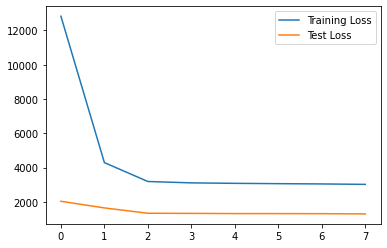

[9,     1] loss: 73.673
[9,     2] loss: 60.075
[9,     3] loss: 78.271
[9,     4] loss: 59.739
[9,     5] loss: 81.284
[9,     6] loss: 68.693
[9,     7] loss: 66.926
[9,     8] loss: 67.154
[9,     9] loss: 65.679
[9,    10] loss: 68.457
[9,    11] loss: 68.752
[9,    12] loss: 65.014
[9,    13] loss: 78.562
[9,    14] loss: 61.353
[9,    15] loss: 67.505
[9,    16] loss: 64.471
[9,    17] loss: 60.351
[9,    18] loss: 62.361
[9,    19] loss: 68.041
[9,    20] loss: 74.162
[9,    21] loss: 70.131
[9,    22] loss: 67.707
[9,    23] loss: 63.964
[9,    24] loss: 70.906
[9,    25] loss: 67.808
[9,    26] loss: 64.601
[9,    27] loss: 63.161
[9,    28] loss: 75.063
[9,    29] loss: 72.263
[9,    30] loss: 72.207
[9,    31] loss: 62.143
[9,    32] loss: 65.736
[9,    33] loss: 62.168
[9,    34] loss: 66.715
[9,    35] loss: 59.005
[9,    36] loss: 71.190
[9,    37] loss: 70.501
[9,    38] loss: 67.668
[9,    39] loss: 60.912
[9,    40] loss: 69.915
[9,    41] loss: 73.196
[9,    42] loss:

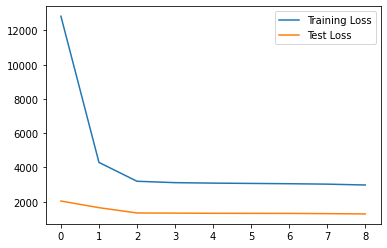

[10,     1] loss: 72.181
[10,     2] loss: 58.238
[10,     3] loss: 76.177
[10,     4] loss: 57.914
[10,     5] loss: 79.080
[10,     6] loss: 65.288
[10,     7] loss: 64.884
[10,     8] loss: 63.891
[10,     9] loss: 64.282
[10,    10] loss: 65.625
[10,    11] loss: 67.333
[10,    12] loss: 62.021
[10,    13] loss: 75.682
[10,    14] loss: 59.023
[10,    15] loss: 65.461
[10,    16] loss: 60.925
[10,    17] loss: 58.555
[10,    18] loss: 58.686
[10,    19] loss: 64.626
[10,    20] loss: 71.020
[10,    21] loss: 67.287
[10,    22] loss: 63.404
[10,    23] loss: 60.730
[10,    24] loss: 66.594
[10,    25] loss: 63.487
[10,    26] loss: 60.758
[10,    27] loss: 60.525
[10,    28] loss: 71.009
[10,    29] loss: 66.898
[10,    30] loss: 64.131
[10,    31] loss: 59.106
[10,    32] loss: 61.052
[10,    33] loss: 57.253
[10,    34] loss: 62.063
[10,    35] loss: 56.778
[10,    36] loss: 65.860
[10,    37] loss: 64.554
[10,    38] loss: 62.043
[10,    39] loss: 57.451
[10,    40] loss: 64.404


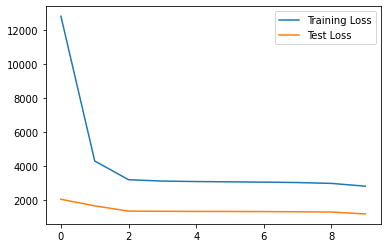

[11,     1] loss: 63.879
[11,     2] loss: 54.272
[11,     3] loss: 68.869
[11,     4] loss: 54.970
[11,     5] loss: 72.897
[11,     6] loss: 58.153
[11,     7] loss: 57.725
[11,     8] loss: 60.004
[11,     9] loss: 60.185
[11,    10] loss: 60.618
[11,    11] loss: 64.217
[11,    12] loss: 57.821
[11,    13] loss: 69.120
[11,    14] loss: 55.776
[11,    15] loss: 59.477
[11,    16] loss: 55.757
[11,    17] loss: 53.954
[11,    18] loss: 55.187
[11,    19] loss: 59.906
[11,    20] loss: 65.939
[11,    21] loss: 63.517
[11,    22] loss: 57.551
[11,    23] loss: 56.836
[11,    24] loss: 62.294
[11,    25] loss: 59.339
[11,    26] loss: 57.731
[11,    27] loss: 58.239
[11,    28] loss: 66.425
[11,    29] loss: 60.978
[11,    30] loss: 58.445
[11,    31] loss: 56.652
[11,    32] loss: 57.346
[11,    33] loss: 54.127
[11,    34] loss: 59.080
[11,    35] loss: 54.067
[11,    36] loss: 63.043
[11,    37] loss: 60.119
[11,    38] loss: 59.499
[11,    39] loss: 54.965
[11,    40] loss: 61.622


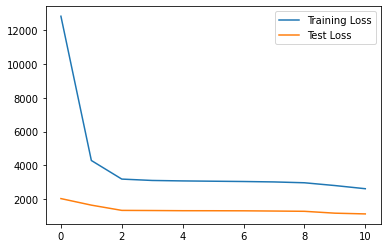

[12,     1] loss: 60.697
[12,     2] loss: 52.128
[12,     3] loss: 66.189
[12,     4] loss: 53.141
[12,     5] loss: 68.727
[12,     6] loss: 56.005
[12,     7] loss: 55.389
[12,     8] loss: 58.008
[12,     9] loss: 57.771
[12,    10] loss: 58.634
[12,    11] loss: 61.746
[12,    12] loss: 55.696
[12,    13] loss: 67.170
[12,    14] loss: 53.889
[12,    15] loss: 57.063
[12,    16] loss: 53.618
[12,    17] loss: 52.480
[12,    18] loss: 53.442
[12,    19] loss: 57.680
[12,    20] loss: 63.535
[12,    21] loss: 60.698
[12,    22] loss: 55.029
[12,    23] loss: 54.124
[12,    24] loss: 60.153
[12,    25] loss: 57.414
[12,    26] loss: 56.462
[12,    27] loss: 56.174
[12,    28] loss: 64.200
[12,    29] loss: 59.345
[12,    30] loss: 56.298
[12,    31] loss: 55.334
[12,    32] loss: 55.661
[12,    33] loss: 52.036
[12,    34] loss: 57.927
[12,    35] loss: 52.944
[12,    36] loss: 60.843
[12,    37] loss: 57.761
[12,    38] loss: 58.322
[12,    39] loss: 53.693
[12,    40] loss: 59.691


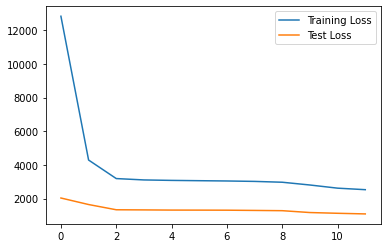

[13,     1] loss: 58.127
[13,     2] loss: 51.366
[13,     3] loss: 63.803
[13,     4] loss: 51.231
[13,     5] loss: 65.571
[13,     6] loss: 54.782
[13,     7] loss: 53.177
[13,     8] loss: 56.531
[13,     9] loss: 56.151
[13,    10] loss: 56.758
[13,    11] loss: 59.830
[13,    12] loss: 53.787
[13,    13] loss: 65.287
[13,    14] loss: 52.414
[13,    15] loss: 54.854
[13,    16] loss: 51.843
[13,    17] loss: 50.779
[13,    18] loss: 51.359
[13,    19] loss: 56.088
[13,    20] loss: 60.536
[13,    21] loss: 58.376
[13,    22] loss: 52.918
[13,    23] loss: 51.871
[13,    24] loss: 58.358
[13,    25] loss: 56.133
[13,    26] loss: 55.143
[13,    27] loss: 54.365
[13,    28] loss: 61.926
[13,    29] loss: 57.750
[13,    30] loss: 55.564
[13,    31] loss: 54.095
[13,    32] loss: 54.559
[13,    33] loss: 50.424
[13,    34] loss: 56.801
[13,    35] loss: 53.880
[13,    36] loss: 58.978
[13,    37] loss: 56.239
[13,    38] loss: 57.941
[13,    39] loss: 52.427
[13,    40] loss: 59.024


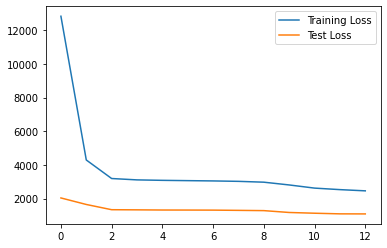

[14,     1] loss: 56.846
[14,     2] loss: 50.740
[14,     3] loss: 62.530
[14,     4] loss: 50.882
[14,     5] loss: 62.367
[14,     6] loss: 53.641
[14,     7] loss: 51.563
[14,     8] loss: 55.017
[14,     9] loss: 54.781
[14,    10] loss: 55.413
[14,    11] loss: 58.403
[14,    12] loss: 52.343
[14,    13] loss: 63.874
[14,    14] loss: 51.276
[14,    15] loss: 54.010
[14,    16] loss: 51.220
[14,    17] loss: 49.716
[14,    18] loss: 50.403
[14,    19] loss: 55.266
[14,    20] loss: 59.096
[14,    21] loss: 56.299
[14,    22] loss: 51.426
[14,    23] loss: 50.601
[14,    24] loss: 56.760
[14,    25] loss: 54.046
[14,    26] loss: 53.537
[14,    27] loss: 53.138
[14,    28] loss: 59.918
[14,    29] loss: 53.980
[14,    30] loss: 52.132
[14,    31] loss: 53.349
[14,    32] loss: 50.931
[14,    33] loss: 48.252
[14,    34] loss: 54.852
[14,    35] loss: 50.871
[14,    36] loss: 56.951
[14,    37] loss: 54.240
[14,    38] loss: 54.970
[14,    39] loss: 50.573
[14,    40] loss: 57.037


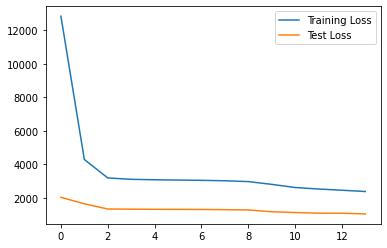

[15,     1] loss: 54.375
[15,     2] loss: 49.859
[15,     3] loss: 60.597
[15,     4] loss: 48.513
[15,     5] loss: 60.214
[15,     6] loss: 52.233
[15,     7] loss: 50.126
[15,     8] loss: 53.328
[15,     9] loss: 53.241
[15,    10] loss: 54.065
[15,    11] loss: 56.796
[15,    12] loss: 51.090
[15,    13] loss: 61.969
[15,    14] loss: 50.311
[15,    15] loss: 52.054
[15,    16] loss: 49.780
[15,    17] loss: 48.904
[15,    18] loss: 48.651
[15,    19] loss: 54.177
[15,    20] loss: 56.788
[15,    21] loss: 54.764
[15,    22] loss: 49.667
[15,    23] loss: 49.437
[15,    24] loss: 56.000
[15,    25] loss: 52.627
[15,    26] loss: 52.508
[15,    27] loss: 51.843
[15,    28] loss: 58.550
[15,    29] loss: 51.898
[15,    30] loss: 50.931
[15,    31] loss: 52.053
[15,    32] loss: 49.428
[15,    33] loss: 47.324
[15,    34] loss: 53.680
[15,    35] loss: 49.977
[15,    36] loss: 55.748
[15,    37] loss: 53.165
[15,    38] loss: 54.035
[15,    39] loss: 49.718
[15,    40] loss: 55.875


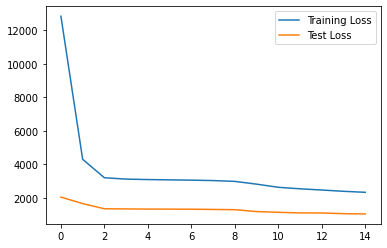

[16,     1] loss: 53.045
[16,     2] loss: 49.216
[16,     3] loss: 59.391
[16,     4] loss: 47.890
[16,     5] loss: 58.683
[16,     6] loss: 51.400
[16,     7] loss: 48.869
[16,     8] loss: 52.383
[16,     9] loss: 52.234
[16,    10] loss: 52.981
[16,    11] loss: 55.654
[16,    12] loss: 50.047
[16,    13] loss: 60.625
[16,    14] loss: 49.533
[16,    15] loss: 50.896
[16,    16] loss: 49.263
[16,    17] loss: 48.117
[16,    18] loss: 47.761
[16,    19] loss: 53.537
[16,    20] loss: 55.444
[16,    21] loss: 53.384
[16,    22] loss: 48.756
[16,    23] loss: 48.441
[16,    24] loss: 55.296
[16,    25] loss: 52.314
[16,    26] loss: 51.770
[16,    27] loss: 51.163
[16,    28] loss: 57.907
[16,    29] loss: 50.588
[16,    30] loss: 50.016
[16,    31] loss: 51.463
[16,    32] loss: 48.243
[16,    33] loss: 46.582
[16,    34] loss: 52.580
[16,    35] loss: 49.231
[16,    36] loss: 54.606
[16,    37] loss: 52.094
[16,    38] loss: 53.148
[16,    39] loss: 48.847
[16,    40] loss: 54.607


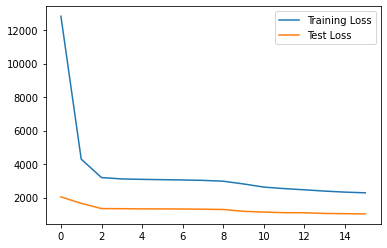

[17,     1] loss: 51.929
[17,     2] loss: 48.370
[17,     3] loss: 58.227
[17,     4] loss: 46.966
[17,     5] loss: 57.402
[17,     6] loss: 50.519
[17,     7] loss: 47.903
[17,     8] loss: 51.302
[17,     9] loss: 51.079
[17,    10] loss: 52.052
[17,    11] loss: 54.671
[17,    12] loss: 48.937
[17,    13] loss: 59.356
[17,    14] loss: 48.814
[17,    15] loss: 50.110
[17,    16] loss: 48.257
[17,    17] loss: 47.078
[17,    18] loss: 47.015
[17,    19] loss: 52.664
[17,    20] loss: 54.396
[17,    21] loss: 52.228
[17,    22] loss: 47.694
[17,    23] loss: 47.569
[17,    24] loss: 54.219
[17,    25] loss: 50.839
[17,    26] loss: 50.799
[17,    27] loss: 50.108
[17,    28] loss: 56.308
[17,    29] loss: 49.369
[17,    30] loss: 49.151
[17,    31] loss: 50.571
[17,    32] loss: 47.261
[17,    33] loss: 45.918
[17,    34] loss: 51.614
[17,    35] loss: 48.409
[17,    36] loss: 53.751
[17,    37] loss: 51.171
[17,    38] loss: 52.388
[17,    39] loss: 48.163
[17,    40] loss: 53.450


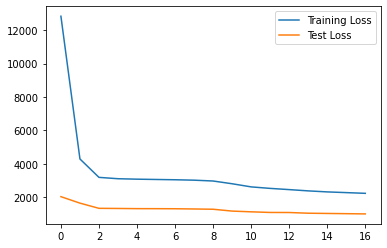

[18,     1] loss: 50.756
[18,     2] loss: 47.780
[18,     3] loss: 56.809
[18,     4] loss: 46.128
[18,     5] loss: 56.180
[18,     6] loss: 49.782
[18,     7] loss: 46.945
[18,     8] loss: 50.389
[18,     9] loss: 50.024
[18,    10] loss: 51.176
[18,    11] loss: 53.815
[18,    12] loss: 47.886
[18,    13] loss: 58.379
[18,    14] loss: 48.020
[18,    15] loss: 49.469
[18,    16] loss: 47.667
[18,    17] loss: 46.131
[18,    18] loss: 46.253
[18,    19] loss: 51.930
[18,    20] loss: 53.339
[18,    21] loss: 51.570
[18,    22] loss: 47.167
[18,    23] loss: 46.953
[18,    24] loss: 53.423
[18,    25] loss: 49.400
[18,    26] loss: 50.378
[18,    27] loss: 48.708
[18,    28] loss: 54.823
[18,    29] loss: 48.350
[18,    30] loss: 47.858
[18,    31] loss: 49.598
[18,    32] loss: 46.234
[18,    33] loss: 44.843
[18,    34] loss: 50.608
[18,    35] loss: 47.289
[18,    36] loss: 52.718
[18,    37] loss: 50.137
[18,    38] loss: 51.051
[18,    39] loss: 47.318
[18,    40] loss: 52.228


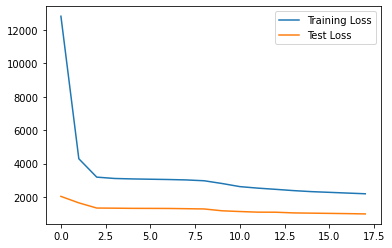

[19,     1] loss: 49.580
[19,     2] loss: 47.090
[19,     3] loss: 55.461
[19,     4] loss: 45.189
[19,     5] loss: 55.168
[19,     6] loss: 48.977
[19,     7] loss: 46.032
[19,     8] loss: 49.461
[19,     9] loss: 49.036
[19,    10] loss: 50.147
[19,    11] loss: 52.732
[19,    12] loss: 46.781
[19,    13] loss: 57.194
[19,    14] loss: 47.182
[19,    15] loss: 48.768
[19,    16] loss: 46.819
[19,    17] loss: 45.189
[19,    18] loss: 45.441
[19,    19] loss: 50.940
[19,    20] loss: 52.222
[19,    21] loss: 50.529
[19,    22] loss: 46.000
[19,    23] loss: 46.408
[19,    24] loss: 52.100
[19,    25] loss: 48.383
[19,    26] loss: 49.442
[19,    27] loss: 47.637
[19,    28] loss: 53.708
[19,    29] loss: 47.086
[19,    30] loss: 46.971
[19,    31] loss: 48.437
[19,    32] loss: 45.562
[19,    33] loss: 44.019
[19,    34] loss: 49.634
[19,    35] loss: 46.314
[19,    36] loss: 51.491
[19,    37] loss: 48.860
[19,    38] loss: 49.949
[19,    39] loss: 46.591
[19,    40] loss: 50.929


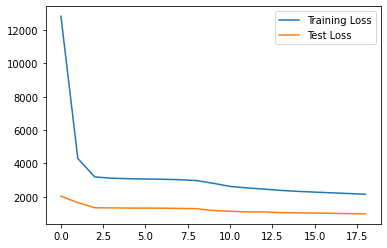

[20,     1] loss: 48.505
[20,     2] loss: 45.966
[20,     3] loss: 53.796
[20,     4] loss: 44.449
[20,     5] loss: 53.746
[20,     6] loss: 47.953
[20,     7] loss: 45.224
[20,     8] loss: 48.316
[20,     9] loss: 48.113
[20,    10] loss: 48.752
[20,    11] loss: 51.432
[20,    12] loss: 45.679
[20,    13] loss: 55.552
[20,    14] loss: 46.286
[20,    15] loss: 47.493
[20,    16] loss: 45.541
[20,    17] loss: 44.208
[20,    18] loss: 44.194
[20,    19] loss: 49.900
[20,    20] loss: 50.863
[20,    21] loss: 48.977
[20,    22] loss: 45.139
[20,    23] loss: 45.399
[20,    24] loss: 51.226
[20,    25] loss: 46.778
[20,    26] loss: 48.243
[20,    27] loss: 46.575
[20,    28] loss: 52.031
[20,    29] loss: 45.880
[20,    30] loss: 45.620
[20,    31] loss: 47.222
[20,    32] loss: 44.351
[20,    33] loss: 42.951
[20,    34] loss: 48.378
[20,    35] loss: 45.063
[20,    36] loss: 50.191
[20,    37] loss: 47.892
[20,    38] loss: 48.472
[20,    39] loss: 45.473
[20,    40] loss: 49.593


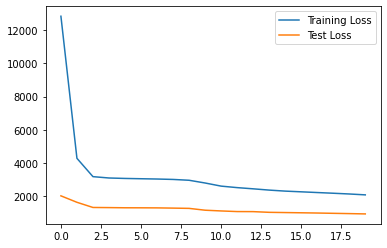

[21,     1] loss: 47.055
[21,     2] loss: 44.768
[21,     3] loss: 51.778
[21,     4] loss: 43.427
[21,     5] loss: 52.409
[21,     6] loss: 46.624
[21,     7] loss: 44.011
[21,     8] loss: 47.195
[21,     9] loss: 47.230
[21,    10] loss: 47.510
[21,    11] loss: 50.117
[21,    12] loss: 44.607
[21,    13] loss: 53.945
[21,    14] loss: 45.306
[21,    15] loss: 46.295
[21,    16] loss: 44.444
[21,    17] loss: 43.044
[21,    18] loss: 43.143
[21,    19] loss: 48.591
[21,    20] loss: 49.439
[21,    21] loss: 47.441
[21,    22] loss: 43.720
[21,    23] loss: 44.114
[21,    24] loss: 49.860
[21,    25] loss: 45.458
[21,    26] loss: 46.888
[21,    27] loss: 45.576
[21,    28] loss: 50.824
[21,    29] loss: 45.048
[21,    30] loss: 44.637
[21,    31] loss: 46.044
[21,    32] loss: 43.133
[21,    33] loss: 42.534
[21,    34] loss: 47.464
[21,    35] loss: 44.246
[21,    36] loss: 49.356
[21,    37] loss: 47.397
[21,    38] loss: 47.744
[21,    39] loss: 44.278
[21,    40] loss: 48.811


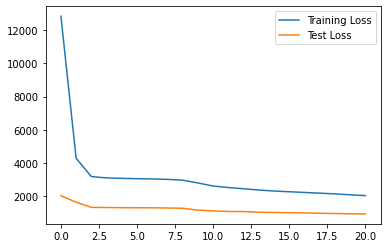

[22,     1] loss: 46.097
[22,     2] loss: 43.858
[22,     3] loss: 50.189
[22,     4] loss: 42.975
[22,     5] loss: 52.152
[22,     6] loss: 45.511
[22,     7] loss: 43.361
[22,     8] loss: 46.580
[22,     9] loss: 47.093
[22,    10] loss: 47.430
[22,    11] loss: 49.368
[22,    12] loss: 44.618
[22,    13] loss: 53.101
[22,    14] loss: 45.149
[22,    15] loss: 45.790
[22,    16] loss: 44.444
[22,    17] loss: 42.296
[22,    18] loss: 42.939
[22,    19] loss: 47.707
[22,    20] loss: 48.333
[22,    21] loss: 47.004
[22,    22] loss: 42.773
[22,    23] loss: 43.702
[22,    24] loss: 48.143
[22,    25] loss: 44.192
[22,    26] loss: 46.238
[22,    27] loss: 44.437
[22,    28] loss: 49.233
[22,    29] loss: 43.798
[22,    30] loss: 43.180
[22,    31] loss: 45.081
[22,    32] loss: 41.725
[22,    33] loss: 41.168
[22,    34] loss: 45.931
[22,    35] loss: 42.999
[22,    36] loss: 47.780
[22,    37] loss: 45.661
[22,    38] loss: 46.236
[22,    39] loss: 43.437
[22,    40] loss: 47.373


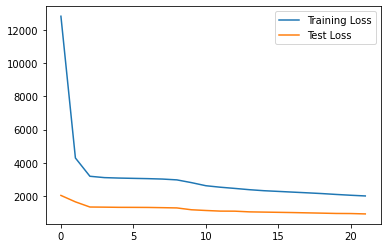

[23,     1] loss: 44.430
[23,     2] loss: 43.108
[23,     3] loss: 48.803
[23,     4] loss: 41.918
[23,     5] loss: 50.419
[23,     6] loss: 44.695
[23,     7] loss: 42.236
[23,     8] loss: 45.187
[23,     9] loss: 45.559
[23,    10] loss: 45.404
[23,    11] loss: 48.413
[23,    12] loss: 42.656
[23,    13] loss: 51.509
[23,    14] loss: 43.535
[23,    15] loss: 44.758
[23,    16] loss: 42.835
[23,    17] loss: 41.277
[23,    18] loss: 41.567
[23,    19] loss: 46.337
[23,    20] loss: 46.832
[23,    21] loss: 45.246
[23,    22] loss: 41.450
[23,    23] loss: 41.929
[23,    24] loss: 47.020
[23,    25] loss: 42.872
[23,    26] loss: 44.727
[23,    27] loss: 43.514
[23,    28] loss: 47.528
[23,    29] loss: 42.409
[23,    30] loss: 41.954
[23,    31] loss: 43.852
[23,    32] loss: 40.858
[23,    33] loss: 40.435
[23,    34] loss: 44.776
[23,    35] loss: 42.109
[23,    36] loss: 47.075
[23,    37] loss: 44.599
[23,    38] loss: 45.019
[23,    39] loss: 42.481
[23,    40] loss: 46.580


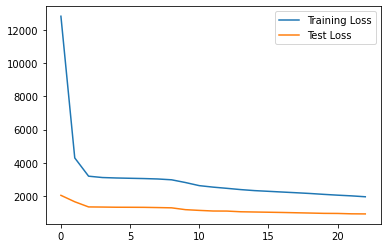

[24,     1] loss: 43.678
[24,     2] loss: 42.238
[24,     3] loss: 48.044
[24,     4] loss: 42.020
[24,     5] loss: 49.407
[24,     6] loss: 43.836
[24,     7] loss: 41.422
[24,     8] loss: 44.658
[24,     9] loss: 44.952
[24,    10] loss: 44.758
[24,    11] loss: 47.341
[24,    12] loss: 41.904
[24,    13] loss: 50.667
[24,    14] loss: 42.675
[24,    15] loss: 44.146
[24,    16] loss: 42.261
[24,    17] loss: 40.283
[24,    18] loss: 41.151
[24,    19] loss: 45.504
[24,    20] loss: 45.724
[24,    21] loss: 44.878
[24,    22] loss: 40.878
[24,    23] loss: 41.380
[24,    24] loss: 46.897
[24,    25] loss: 42.063
[24,    26] loss: 43.910
[24,    27] loss: 42.729
[24,    28] loss: 46.566
[24,    29] loss: 41.455
[24,    30] loss: 41.174
[24,    31] loss: 42.885
[24,    32] loss: 39.836
[24,    33] loss: 39.428
[24,    34] loss: 43.884
[24,    35] loss: 40.939
[24,    36] loss: 45.981
[24,    37] loss: 43.455
[24,    38] loss: 44.225
[24,    39] loss: 41.793
[24,    40] loss: 45.600


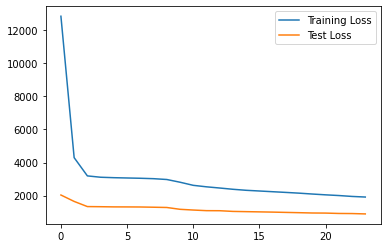

[25,     1] loss: 42.411
[25,     2] loss: 41.173
[25,     3] loss: 45.420
[25,     4] loss: 39.688
[25,     5] loss: 48.033
[25,     6] loss: 42.628
[25,     7] loss: 40.315
[25,     8] loss: 43.264
[25,     9] loss: 43.067
[25,    10] loss: 43.847
[25,    11] loss: 45.905
[25,    12] loss: 41.196
[25,    13] loss: 49.446
[25,    14] loss: 42.017
[25,    15] loss: 43.329
[25,    16] loss: 42.180
[25,    17] loss: 39.892
[25,    18] loss: 40.233
[25,    19] loss: 44.799
[25,    20] loss: 44.420
[25,    21] loss: 44.026
[25,    22] loss: 39.750
[25,    23] loss: 40.772
[25,    24] loss: 45.194
[25,    25] loss: 40.859
[25,    26] loss: 43.457
[25,    27] loss: 41.639
[25,    28] loss: 45.625
[25,    29] loss: 40.659
[25,    30] loss: 40.364
[25,    31] loss: 41.940
[25,    32] loss: 38.786
[25,    33] loss: 38.683
[25,    34] loss: 42.899
[25,    35] loss: 40.244
[25,    36] loss: 45.047
[25,    37] loss: 42.566
[25,    38] loss: 43.518
[25,    39] loss: 40.825
[25,    40] loss: 44.522


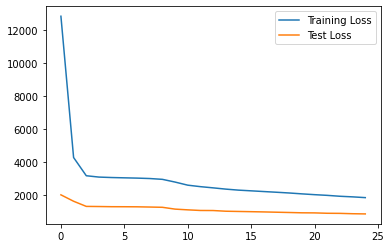

[26,     1] loss: 41.328
[26,     2] loss: 40.643
[26,     3] loss: 44.551
[26,     4] loss: 39.002
[26,     5] loss: 46.876
[26,     6] loss: 41.768
[26,     7] loss: 39.458
[26,     8] loss: 42.063
[26,     9] loss: 42.245
[26,    10] loss: 42.742
[26,    11] loss: 45.008
[26,    12] loss: 39.874
[26,    13] loss: 48.424
[26,    14] loss: 40.751
[26,    15] loss: 42.670
[26,    16] loss: 40.782
[26,    17] loss: 38.905
[26,    18] loss: 39.268
[26,    19] loss: 43.720
[26,    20] loss: 43.456
[26,    21] loss: 42.674
[26,    22] loss: 39.249
[26,    23] loss: 39.599
[26,    24] loss: 44.099
[26,    25] loss: 40.179
[26,    26] loss: 42.045
[26,    27] loss: 40.764
[26,    28] loss: 44.222
[26,    29] loss: 39.866
[26,    30] loss: 39.234
[26,    31] loss: 40.996
[26,    32] loss: 38.306
[26,    33] loss: 37.845
[26,    34] loss: 42.137
[26,    35] loss: 39.584
[26,    36] loss: 44.325
[26,    37] loss: 41.759
[26,    38] loss: 42.658
[26,    39] loss: 40.243
[26,    40] loss: 43.532


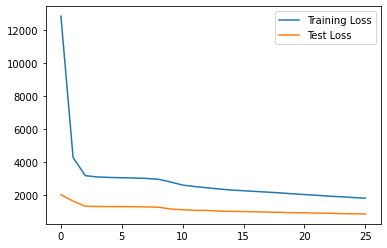

[27,     1] loss: 40.650
[27,     2] loss: 40.003
[27,     3] loss: 43.759
[27,     4] loss: 38.322
[27,     5] loss: 45.793
[27,     6] loss: 41.268
[27,     7] loss: 38.569
[27,     8] loss: 41.106
[27,     9] loss: 41.289
[27,    10] loss: 41.824
[27,    11] loss: 44.049
[27,    12] loss: 39.036
[27,    13] loss: 46.942
[27,    14] loss: 40.030
[27,    15] loss: 41.715
[27,    16] loss: 39.996
[27,    17] loss: 38.069
[27,    18] loss: 38.403
[27,    19] loss: 42.733
[27,    20] loss: 42.225
[27,    21] loss: 41.792
[27,    22] loss: 38.286
[27,    23] loss: 38.718
[27,    24] loss: 42.951
[27,    25] loss: 38.947
[27,    26] loss: 41.191
[27,    27] loss: 39.867
[27,    28] loss: 43.189
[27,    29] loss: 38.817
[27,    30] loss: 38.298
[27,    31] loss: 40.002
[27,    32] loss: 37.169
[27,    33] loss: 36.991
[27,    34] loss: 41.052
[27,    35] loss: 38.745
[27,    36] loss: 43.157
[27,    37] loss: 40.807
[27,    38] loss: 41.706
[27,    39] loss: 39.689
[27,    40] loss: 42.608


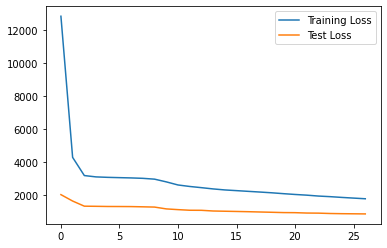

[28,     1] loss: 39.929
[28,     2] loss: 39.054
[28,     3] loss: 42.857
[28,     4] loss: 37.548
[28,     5] loss: 45.099
[28,     6] loss: 40.326
[28,     7] loss: 38.266
[28,     8] loss: 40.206
[28,     9] loss: 40.853
[28,    10] loss: 40.998
[28,    11] loss: 43.492
[28,    12] loss: 38.742
[28,    13] loss: 45.974
[28,    14] loss: 39.527
[28,    15] loss: 40.827
[28,    16] loss: 39.594
[28,    17] loss: 37.342
[28,    18] loss: 37.931
[28,    19] loss: 42.129
[28,    20] loss: 41.506
[28,    21] loss: 40.699
[28,    22] loss: 37.508
[28,    23] loss: 37.767
[28,    24] loss: 42.224
[28,    25] loss: 38.011
[28,    26] loss: 40.360
[28,    27] loss: 38.906
[28,    28] loss: 42.067
[28,    29] loss: 38.259
[28,    30] loss: 37.476
[28,    31] loss: 39.278
[28,    32] loss: 36.404
[28,    33] loss: 36.332
[28,    34] loss: 40.240
[28,    35] loss: 38.167
[28,    36] loss: 42.379
[28,    37] loss: 39.977
[28,    38] loss: 40.939
[28,    39] loss: 39.140
[28,    40] loss: 41.563


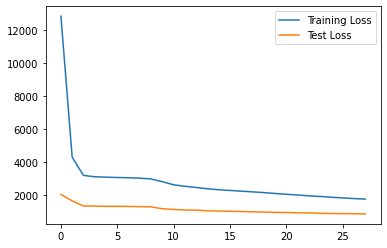

[29,     1] loss: 38.976
[29,     2] loss: 38.907
[29,     3] loss: 42.168
[29,     4] loss: 36.951
[29,     5] loss: 44.265
[29,     6] loss: 39.558
[29,     7] loss: 37.865
[29,     8] loss: 39.244
[29,     9] loss: 40.241
[29,    10] loss: 40.111
[29,    11] loss: 42.822
[29,    12] loss: 38.006
[29,    13] loss: 44.909
[29,    14] loss: 39.043
[29,    15] loss: 40.410
[29,    16] loss: 38.643
[29,    17] loss: 36.653
[29,    18] loss: 37.595
[29,    19] loss: 41.246
[29,    20] loss: 40.649
[29,    21] loss: 40.460
[29,    22] loss: 37.171
[29,    23] loss: 37.392
[29,    24] loss: 41.941
[29,    25] loss: 37.764
[29,    26] loss: 39.715
[29,    27] loss: 38.494
[29,    28] loss: 41.605
[29,    29] loss: 37.490
[29,    30] loss: 36.895
[29,    31] loss: 38.649
[29,    32] loss: 36.108
[29,    33] loss: 35.689
[29,    34] loss: 40.244
[29,    35] loss: 37.270
[29,    36] loss: 41.623
[29,    37] loss: 40.023
[29,    38] loss: 41.100
[29,    39] loss: 38.805
[29,    40] loss: 41.000


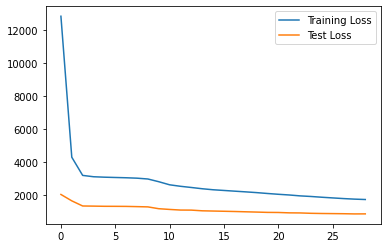

[30,     1] loss: 38.919
[30,     2] loss: 37.983
[30,     3] loss: 40.742
[30,     4] loss: 36.598
[30,     5] loss: 43.892
[30,     6] loss: 38.501
[30,     7] loss: 36.854
[30,     8] loss: 38.883
[30,     9] loss: 38.700
[30,    10] loss: 39.517
[30,    11] loss: 41.653
[30,    12] loss: 37.350
[30,    13] loss: 43.969
[30,    14] loss: 38.230
[30,    15] loss: 39.109
[30,    16] loss: 37.400
[30,    17] loss: 35.912
[30,    18] loss: 36.318
[30,    19] loss: 40.330
[30,    20] loss: 39.867
[30,    21] loss: 39.079
[30,    22] loss: 35.792
[30,    23] loss: 37.565
[30,    24] loss: 40.735
[30,    25] loss: 36.096
[30,    26] loss: 39.087
[30,    27] loss: 38.141
[30,    28] loss: 40.504
[30,    29] loss: 36.696
[30,    30] loss: 38.094
[30,    31] loss: 39.541
[30,    32] loss: 34.886
[30,    33] loss: 36.791
[30,    34] loss: 39.283
[30,    35] loss: 36.789
[30,    36] loss: 41.601
[30,    37] loss: 39.403
[30,    38] loss: 39.637
[30,    39] loss: 37.504
[30,    40] loss: 40.034


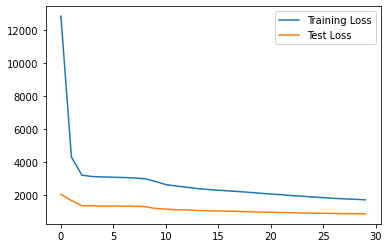

Finished Training


In [25]:
train_loss_graph = []
test_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)
          

print('Finished Training')

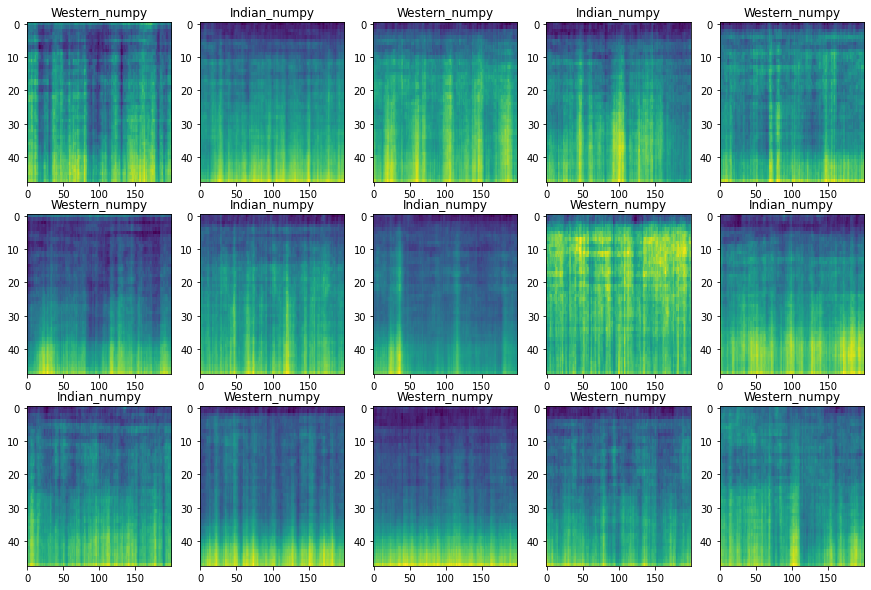

In [26]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

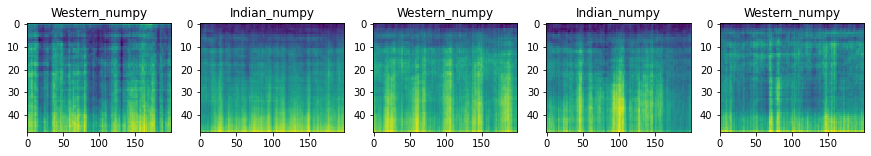

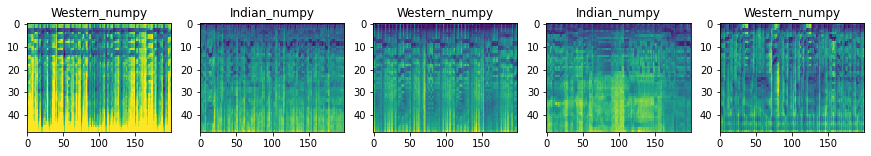

In [27]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        outputs.append((mel_display(image.detach().cpu().unsqueeze(dim=0)),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [28]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [30]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "final_model.pt"), map_location=device))

<All keys matched successfully>

In [31]:
combined_dataset = MEL_Dataset(dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
combinedloader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size)

In [35]:
dataDF
dataDF.loc[1, 'labels']
classes
os.path.join(BASE_PATH, "Activations_64", str(classes[label]))

TypeError: ignored

In [40]:
# # get some random training images
# dataiter = iter(combinedloader)
# images, labels = dataiter.next()
# arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# # Viewing data examples used for training
# fig, axis = plt.subplots(3, 5, figsize=(15, 10))
# for i, ax in enumerate(axis.flat):
#     with torch.no_grad():
#         image, label = images[i], labels[i]
#         image, labels = image.to(device), labels.to(device)
#         print(image.shape)
#         output_l2, output_l1 = net.encoder(image.unsqueeze(dim=0))
#         print(output_l2.shape)
#         print(output_l1.shape)
id = 0
with torch.no_grad():
    for data in combinedloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        for  arr64, arr128, arr48, label in zip(output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", classes[label] ,  str(id) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", classes[label] ,  str(id) + ".npy"), np.transpose(arr48, (1,0)))
          id = id + 1
          
        
        
          
        
          


/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/Western_numpy/0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/Western_numpy/1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/Western_numpy/2.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/Western_numpy/3.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/Western_numpy/4.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/Western_numpy/5.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/Western_numpy/6.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/Western_numpy/7.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/Western_numpy/8.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/Western_numpy/9.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/Western_numpy/10.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/Activations_64/Western_num